In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [2]:
import torch
import gc
import numpy as np
import torchvision.transforms as T

from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from dataset.reflacx import REFLACXDataset
from IPython.display import clear_output
from utils.plot import plot_train
from utils.device import clean_memory_get_device
from engine.regression import train_one_epoch, evaluate

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [3]:
device = clean_memory_get_device()
torch.set_default_dtype(torch.float32)
# torch.set_default_device(device)

This notebook will running on device: [CUDA]


In [4]:
image_size = 128
batch_size = 8
hidden_dim = 256

In [5]:
train_d = DataLoader(
    REFLACXDataset(
        df_path="./spreadsheets/reflacx_clinical.csv",
        mimic_eye_path="F:\\mimic-eye",
        image_size=image_size,
        split_str="train",
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    drop_last=False,
    # generator=torch.Generator(device=device),
)

val_d = DataLoader(
    REFLACXDataset(
        df_path="./spreadsheets/reflacx_clinical.csv",
        mimic_eye_path="F:\\mimic-eye",
        image_size=image_size,
        split_str="val",
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    drop_last=False,
    # generator=torch.Generator(device=device),
)

test_d = DataLoader(
    REFLACXDataset(
        df_path="./spreadsheets/reflacx_clinical.csv",
        mimic_eye_path="F:\\mimic-eye",
        image_size=image_size,
        split_str="test",
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    drop_last=False,
    # generator=torch.Generator(device=device),
)

In [6]:
from model.transformer import MultimodalTransformer

In [7]:
model = MultimodalTransformer(
    hidden_dim=hidden_dim,  
    tf_layer=8,
    tf_head=4,
)
model.to(device)

optimizer = torch.optim.AdamW(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=1e-4,
    weight_decay=1e-1,
    betas=(0.9, 0.95),
    eps=1e-5,
)

num_epochs=200
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=len(train_d) * num_epochs, eta_min=1e-8
)

criterion = nn.MSELoss()

In [8]:
from utils.model import num_params
num_params(model)
# 11181642
# 7833729

21443585

In [9]:
list(model.parameters())[0].device

device(type='cuda', index=0)

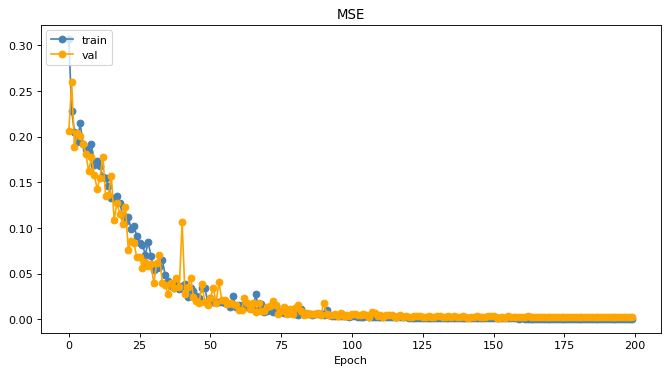

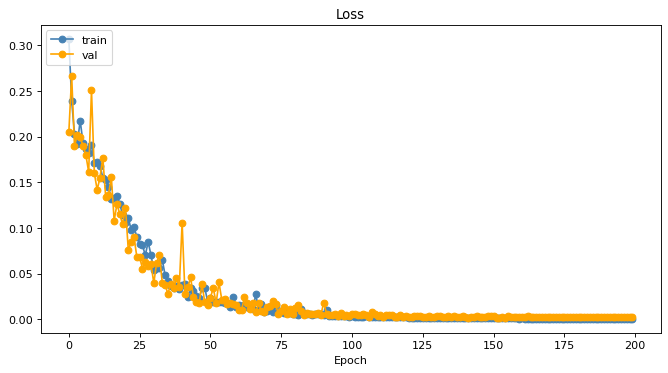

In [10]:
train_perfs = []
val_perfs = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_l, train_eval = train_one_epoch(
        model,
        criterion,
        train_d,
        optimizer,
        device,
        epoch,
        max_norm=1,
        lr_scheduler=scheduler,
    )
    val_l, val_eval = evaluate(model, criterion, val_d, device)
    train_perfs.append(train_eval.get_performance()["MSE"])
    val_perfs.append(val_eval.get_performance()["MSE"])
    train_losses.append(np.mean(train_l))
    val_losses.append(np.mean(val_l))
    clear_output()

    plot_train(train_perfs, val_perfs, "MSE")
    plot_train(train_losses, val_losses, "Loss")